In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import missingno as msno
warnings.filterwarnings('ignore')

In [2]:
db = pd.read_csv("data/fraud_database.csv")

In [3]:
db.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
db['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [6]:
db['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

dataset desbalanceado

In [8]:
db['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [13]:
db.shape

(6362620, 11)

In [14]:
db['step'] = db['step'].astype('category')
db['type'] = db['type'].astype('category')
db['nameOrig'] = db['nameOrig'].astype('category')
db['nameDest'] = db['nameDest'].astype('category')
db['isFraud'] = db['isFraud'].astype('category')
db['isFlaggedFraud'] = db['isFlaggedFraud'].astype('category')

In [15]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            category
 1   type            category
 2   amount          float64 
 3   nameOrig        category
 4   oldbalanceOrg   float64 
 5   newbalanceOrig  float64 
 6   nameDest        category
 7   oldbalanceDest  float64 
 8   newbalanceDest  float64 
 9   isFraud         category
 10  isFlaggedFraud  category
dtypes: category(6), float64(5)
memory usage: 584.4 MB


<Axes: >

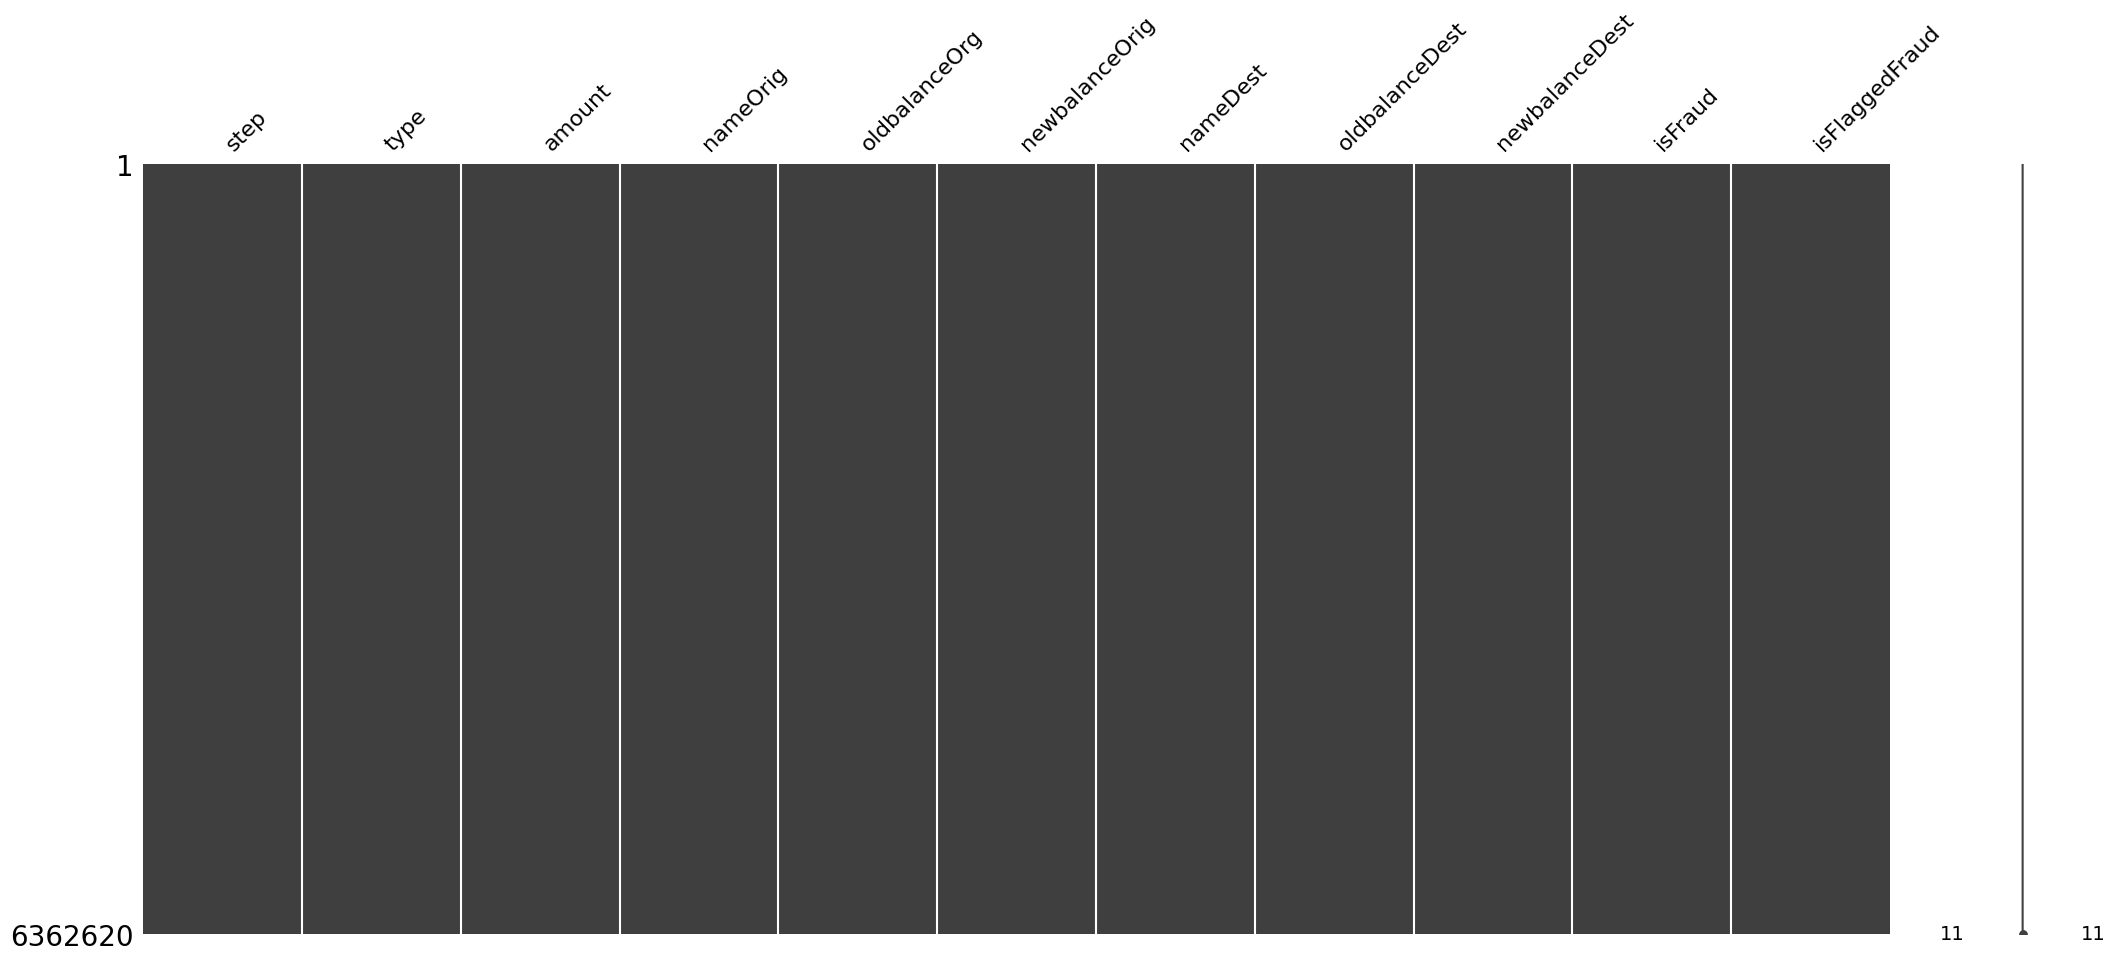

In [25]:
msno.matrix(db)
plt.show()

dataset sem valores faltantes

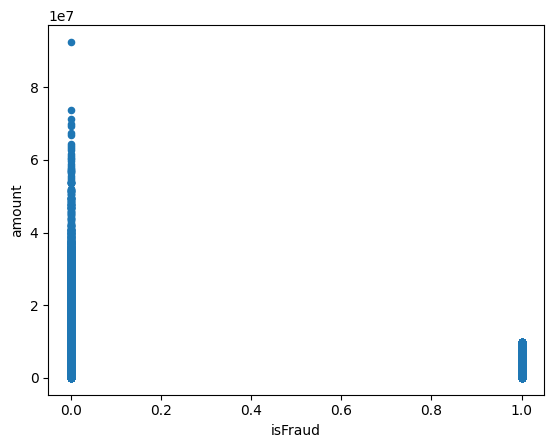

In [19]:
db.plot(
    x='isFraud',
    y='amount',
    kind='scatter'
)
plt.show()

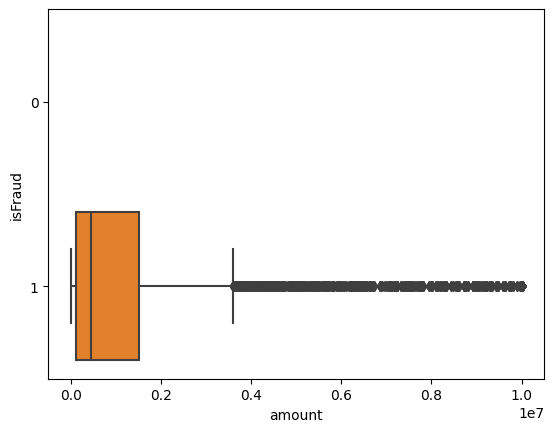

In [30]:
sns.boxplot(
data=db[db['isFraud'] == 1],
x='amount',
y='isFraud',
orient='h'
)
plt.show()

In [35]:
db_isfraud = db[db['isFraud'] == 1]

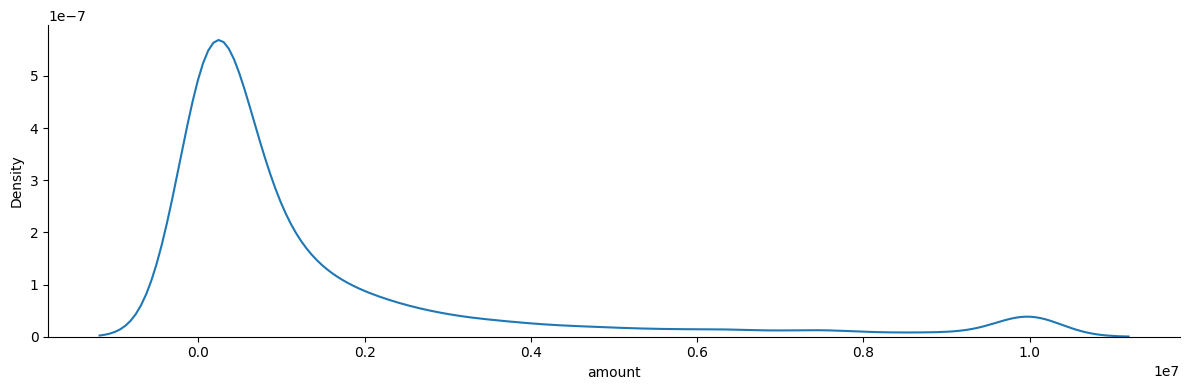

In [36]:
sns.displot(
    db_isfraud['amount'],
    height=4,
    aspect=3,
    kind='kde'
)
plt.show()

In [37]:
db_isfraud.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03
mean,1.467967e+06,1.649668e+06,1.923926e+05,5.442496e+05,1.279708e+06
std,2.404253e+06,3.547719e+06,1.965666e+06,3.336421e+06,3.908817e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.270913e+05,1.258224e+05,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.414234e+05,4.389835e+05,0.000000e+00,0.000000e+00,4.676420e+03
75%,1.517771e+06,1.517771e+06,0.000000e+00,1.478287e+05,1.058725e+06
max,1.000000e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08


In [39]:
db_isfraud['amount'].median()

441423.44

A mediana dos valores de transações fraudulentas é de 441423.44

In [40]:
db_cat = db.select_dtypes(include='category')
db_num = db.select_dtypes(exclude='category')